# Imports

In [1]:
# Standard library imports
import importlib
import gc
import copy

# Third-party imports
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import einops
import matplotlib.pyplot as plt
from transformers import GPT2Model, GPT2Config, GPT2Tokenizer
from datasets import load_dataset
from transformer_lens.utils import tokenize_and_concatenate

# Local imports
import toy_models.xornet
import toy_models.tms
import toy_models.train
import toy_models.transformer_wrapper
import eigenestimation_algorithm.train
import eigenestimation_algorithm.eigenestimation
import eigenestimation_algorithm.evaluation

# Reload modules for interactive sessions
importlib.reload(toy_models.xornet)
importlib.reload(toy_models.tms)
importlib.reload(toy_models.train)
importlib.reload(toy_models.transformer_wrapper)
importlib.reload(eigenestimation_algorithm.train)
importlib.reload(eigenestimation_algorithm.eigenestimation)
importlib.reload(eigenestimation_algorithm.evaluation)

# Specific imports from local modules
from toy_models.xornet import XORNet, GenerateXORData
from toy_models.tms import Autoencoder, GenerateTMSData
from toy_models.train import TrainModel
from toy_models.transformer_wrapper import TransformerWrapper, DeleteParams, KLDivergenceLoss
from eigenestimation_algorithm.eigenestimation import EigenEstimation
from eigenestimation_algorithm.train import TrainEigenEstimation
from eigenestimation_algorithm.evaluation import (
    PrintFeatureVals,
    ActivatingExamples,
    PrintFeatureValsTransformer,
    PrintActivatingExamplesTransformer,
)

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'


/home/ubuntu/brianna-interpretability/eigenestimation_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [91]:
importlib.reload(eigenestimation_algorithm.evaluation)

from eigenestimation_algorithm.evaluation import (
    PrintFeatureVals,
    ActivatingExamples,
    PrintFeatureValsTransformer,
    PrintActivatingExamplesTransformer,
)


# Toy Models

Setup toy models, generate/pull data, and train.

## XORNet

<module 'eigenestimation_algorithm.evaluation' from '/home/ubuntu/brianna-interpretability/eigenestimation/eigenestimation_algorithm/evaluation.py'>

In [13]:
X_xornet, Y_xornet, dataloader_xornet = GenerateXORData(n_repeats=100, batch_size=24)
model_xornet = XORNet().to(device)

In [21]:
X_xornet, Y_xornet, dataloader_xornet = GenerateXORData(n_repeats=100, batch_size=24)
model_xornet = XORNet().to(device)


_, _, _ =TrainModel(
    model=model_xornet,
    criterion=nn.MSELoss(),
    learning_rate=.01,
    dataloader=dataloader_xornet,
    n_epochs=1000,
    device=device
)

Epoch 300, Loss: 0.0003058672300539911


## TMS

Epoch 300, Loss: 0.03502044454216957
Epoch 400, Loss: 0.0001329688384430483
Epoch 500, Loss: 8.670073839311954e-06
Epoch 600, Loss: 0.0001047763362294063
Epoch 700, Loss: 3.223416570108384e-05
Epoch 800, Loss: 0.03689640387892723
Epoch 900, Loss: 0.027663107961416245


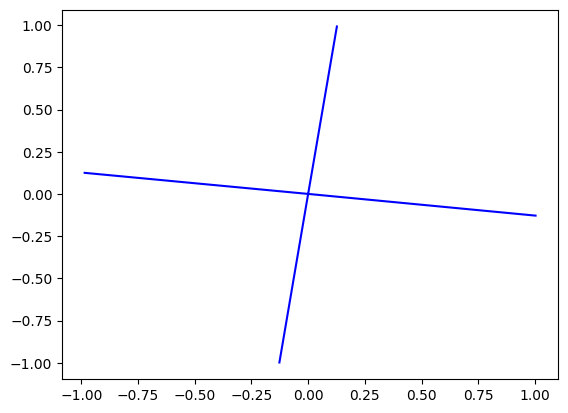

In [22]:
#@title Train TMS
n_features = 5
hidden_dim = 2
n_datapoints = 1024
sparsity = .075

batch_size = 12
learning_rate = .1
n_epochs = 1000

X_tms, Y_tms, dataloader_TMS = GenerateTMSData(
    num_features=n_features, num_datapoints=n_datapoints, sparsity=sparsity, batch_size=batch_size)
tms_model = Autoencoder(n_features, hidden_dim).to(device)
_, _, _ = TrainModel(tms_model, nn.MSELoss(), learning_rate, dataloader_TMS, n_epochs=n_epochs, device=device)


# Plot TMS representations.
en = copy.deepcopy(tms_model.W).detach().cpu().numpy()

for i in range(en.shape[1]):
  plt.plot([0, en[0,i]], [0,en[1,i]], 'b-')
plt.show()

## 2-layer transformer




In [25]:
# @title Import pretrained gpt2 (2 layers)
# Disable fused kernels (FlashAttention and memory-efficient attention)
# We have to disable this to compute second-order gradients on transformer models.
from transformers import AutoModelForCausalLM, AutoTokenizer, GPT2LMHeadModel
import transformer_lens
torch.backends.cuda.enable_flash_sdp(False)
torch.backends.cuda.enable_mem_efficient_sdp(False)

# Ensure the math kernel is enabled (it is True by default)
torch.backends.cuda.enable_math_sdp(True)

# Load in a 2-L GPT2.
#config = GPT2Config.from_pretrained('gpt2', n_layer=2)
#gpt2 = GPT2Model.from_pretrained('gpt2', config=config)
#tokenizer = GPT2Tokenizer.from_pretrained("gpt2",)
#tokenizer.pad_token = tokenizer.eos_token
#transformer_model = TransformerWrapper(gpt2, tokenizer)


gpt2  = transformer_lens.HookedTransformer.from_pretrained('gpt2')
#gpt2  = transformer_lens.HookedTransformer.from_pretrained("roneneldan/TinyStories-1M")#GPT2LMHeadModel.from_pretrained('gpt2', config=config)
tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token
transformer_model = TransformerWrapper(gpt2, tokenizer)

# Make the eigenestimation a little smaller but only looking at a subset of the parameters.
# Pick a random subset of tensors to include in paramters, and turn the rest into frozen buffers.
params_to_delete = [name for name, param in transformer_model.named_parameters()]
params_to_delete = [p for p in params_to_delete if 'blocks.3.attn.W_' not in p]#!='transformer.h.1.ln_2.weight']

# Delete 3/4 of the parameters.
#for p in (params_to_delete[::20]):
#  params_to_delete.remove(p)

DeleteParams(transformer_model, params_to_delete)

print(sum([p.numel() for p in transformer_model.parameters()]))
for n,p in transformer_model.named_parameters(): print(n, p.numel())

Loaded pretrained model gpt2 into HookedTransformer
2359296
transformer.blocks.3.attn.W_Q 589824
transformer.blocks.3.attn.W_O 589824
transformer.blocks.3.attn.W_K 589824
transformer.blocks.3.attn.W_V 589824


In [13]:
# Load in data.
tinystories_dataset = dataset = load_dataset('roneneldan/TinyStories', split="validation[:10%]")
X_transformer= tokenize_and_concatenate(tinystories_dataset, tokenizer, max_length = 32, add_bos_token=True)['tokens']
transformer_dataloader = DataLoader(X_transformer, batch_size=24, shuffle=True)

Map (num_proc=10):   0%|          | 0/2199 [00:00<?, ? examples/s]Token indices sequence length is longer than the specified maximum sequence length for this model (2631 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2279 > 2048). Running this sequence through the model will result in indexing errors
Map (num_proc=10):  10%|█         | 220/2199 [00:00<00:02, 671.73 examples/s]Token indices sequence length is longer than the specified maximum sequence length for this model (2154 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2135 > 2048). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2073 > 2048). Running 

In [14]:
X_transformer.shape

torch.Size([14100, 32])

# Eigenestimation

# Tests on Toy Models


## Xornet

In [6]:
n_u_vectors = 3
batch_size = 32
lambda_penalty = 1
repeats = 24
n_epochs = 100
learning_rate = .01

torch.cuda.empty_cache()
gc.collect()
eigenmodel_xornet = EigenEstimation(model_xornet, nn.MSELoss, n_u_vectors).to(device)

dataloader_xornet_eigen = DataLoader(
    einops.repeat(X_xornet, 's f -> (s r) f', r=repeats), batch_size=batch_size, shuffle=True)

TrainEigenEstimation(eigenmodel_xornet, dataloader_xornet_eigen, learning_rate, n_epochs, lambda_penalty, device=device)

# Clear cuda cache
torch.cuda.empty_cache()
gc.collect()


NameError: name 'model_xornet' is not defined

In [ ]:
# Look at features
PrintFeatureVals(X_xornet, eigenmodel_xornet)

for f_idx in range(eigenmodel_xornet.n_u_vectors):
  sample, val = ActivatingExamples(X_xornet, eigenmodel_xornet, f_idx, 3)
  print('feature', f_idx)
  for s, v in zip(sample, val):
    print(s, '->', v)

## TMS

In [ ]:
#@title Train Eigenmodel
n_u_vectors = 5
batch_size = 24
lambda_penalty = 10
n_epochs = 100
learning_rate = .01


dataloader = DataLoader(X_tms, batch_size=batch_size, shuffle=True,
                               generator=torch.Generator(device='cuda'))
eigenmodel_tms = EigenEstimation(tms_model, nn.MSELoss, n_u_vectors)
TrainEigenEstimation(eigenmodel_tms, dataloader, learning_rate, n_epochs, lambda_penalty)

In [ ]:
#@title Look at features
X = X_tms[:10]
PrintFeatureVals(X_tms[:10], eigenmodel_tms)

for f_idx in range(eigenmodel_tms.n_u_vectors):
  sample, val = ActivatingExamples(X_tms[:100,], eigenmodel_tms, f_idx, 3)
  print('feature', f_idx)
  for s, v in zip(sample, val):
    print(s.round(3), '->', v.round(3))

## 2L Transformer

In [45]:
len(X_transformer[::100,:])

142

In [27]:
#@title Train Eigenmodel
#model = transformer_model
n_u_vectors = 10
batch_size = 8
lambda_penalty = 1
n_epochs = 10
learning_rate = .001
u_batch_size = 10

torch.cuda.empty_cache()
gc.collect()

x_transformer_dataloader = DataLoader(X_transformer[::100], batch_size=batch_size, shuffle=True)

eigenmodel_transformer = EigenEstimation(transformer_model.to(device), 
                          KLDivergenceLoss, n_u_vectors, u_chunk_size=20).to(device)

TrainEigenEstimation(
    eigenmodel_transformer,
    x_transformer_dataloader,
    lr=learning_rate,
    n_epochs= n_epochs,
    lambda_penalty=lambda_penalty,
    u_batch_size = u_batch_size,
    device = device
)

Epoch 0 : 446557888.000,  High Hessian Loss: -222594.219,  Basis Loss: 446780512.000
Epoch 1 : -0.000,  High Hessian Loss: -0.000,  Basis Loss: 0.000
Epoch 2 : -0.000,  High Hessian Loss: -0.000,  Basis Loss: 0.000
Epoch 3 : -0.000,  High Hessian Loss: -0.000,  Basis Loss: 0.000
Epoch 4 : -0.000,  High Hessian Loss: -0.000,  Basis Loss: 0.000
Epoch 5 : -0.000,  High Hessian Loss: -0.000,  Basis Loss: 0.000


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x766d59c87010>>
Traceback (most recent call last):
  File "/home/ubuntu/brianna-interpretability/eigenestimation_venv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Epoch 6 : -0.000,  High Hessian Loss: -0.000,  Basis Loss: 0.000


KeyboardInterrupt: 

In [7]:
len(X_transformer[::100])

142

In [28]:
torch.cuda.empty_cache()
gc.collect()
for n, p in eigenmodel_transformer.model.named_parameters(): print(n, p.numel())
print('\n')
for i in list(range(min(20,eigenmodel_transformer.n_u_vectors))):
  PrintActivatingExamplesTransformer(eigenmodel_transformer, X_transformer[1::10,1:], i, 5, 48, device)
  print('\n')

transformer.blocks.3.attn.W_Q 589824
transformer.blocks.3.attn.W_O 589824
transformer.blocks.3.attn.W_K 589824
transformer.blocks.3.attn.W_V 589824


 can play with the other toys. Go away."newlinenewlineSam is sad. He does not want to play with the other toys.** He** wants to play ->  He (Value: 0.074)
 can play with the other toys. Go away."newlinenewlineSam is sad. He does not want to play with the other toys**.** He wants to play -> . (Value: 0.050)
 him to play** it** again! newlinenewlineSam smiled and said, "Let's number the songs and play them again!" newlinenewlineEveryone cheered and ->  it (Value: 0.049)
," Lily replied with a smile. "I love my suit." newlinenewlineThe bird then said, "I have a bitter taste** in** my mouth. ->  in (Value: 0.036)
Once** upon** a time, there was a little girl named Lily. One day, she got very sick and had to go to the hospital. Her mommy ->  upon (Value: 0.024)


 see it up close. When they reached the model, the little girl was too scared to 

In [80]:
eigenmodel_transformer.u @ eigenmodel_transformer.u.transpose(0,1)

tensor([[ 1.0000e+00,  2.4947e-02,  1.3816e-01, -1.9070e-01,  3.1342e-01,
          1.2991e-01, -3.4025e-01, -8.2488e-02, -3.5166e-01, -1.4883e-01],
        [ 2.4947e-02,  1.0000e+00, -6.0290e-02, -1.6399e-01, -2.7528e-02,
          4.4898e-02, -6.0586e-02,  2.4235e-01,  2.9361e-02,  1.0601e-01],
        [ 1.3816e-01, -6.0290e-02,  1.0000e+00, -3.1174e-01,  3.5248e-01,
          2.8283e-02,  4.7661e-02, -1.4453e-01, -4.5667e-02, -2.4800e-01],
        [-1.9070e-01, -1.6399e-01, -3.1174e-01,  1.0000e+00, -8.1278e-02,
         -1.5037e-01,  1.2420e-01,  1.2400e-01,  2.6263e-01, -1.4811e-01],
        [ 3.1342e-01, -2.7528e-02,  3.5248e-01, -8.1278e-02,  1.0000e+00,
          7.1888e-02,  1.4477e-02, -1.1070e-01, -2.1617e-01, -4.1232e-01],
        [ 1.2991e-01,  4.4898e-02,  2.8283e-02, -1.5037e-01,  7.1888e-02,
          1.0000e+00, -8.4762e-02,  1.7639e-02,  3.7509e-02,  4.3950e-04],
        [-3.4025e-01, -6.0586e-02,  4.7661e-02,  1.2420e-01,  1.4477e-02,
         -8.4762e-02,  1.0000e+0

In [81]:
print(
    abs(torch.tril(eigenmodel_transformer.u @ eigenmodel_transformer.u.transpose(0,1), diagonal=-1)
    ).max())
print((
    torch.tril(eigenmodel_transformer.u @ eigenmodel_transformer.u.transpose(0,1), diagonal=-1)).min()
)
print(abs(
    2*torch.tril(eigenmodel_transformer.u @ eigenmodel_transformer.u.transpose(0,1), diagonal=-1)).mean()
)

tensor(0.4123, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(-0.4123, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.1200, device='cuda:0', grad_fn=<MeanBackward0>)


# SCRATCH

In [6]:
import torch
from torch.func import vmap, vjp, grad

# Define a function with parameters and inputs
def f(x, params):
    # Example function with parameters (a simple linear combination)
    return (x * params).sin().sum()

# HVP function that takes parameters
def hvp_revrev(f, primals, params, *tangents):
    # Compute gradient of f with respect to params only
    grad_f = grad(lambda p: f(primals, p))#(params)
    # Perform VJP to get HVP
    _, vjp_fn = vjp(lambda p: grad_f(primals, p), params)
    print(*tangents)
    return vjp_fn(*tangents)

# Batch sizes for inputs and parameters
batch_size = 2048
num_tangents = 10

# Sample inputs and parameters
x_batch = torch.randn((10, 2), requires_grad=False)  # Input, no gradient needed
params = torch.randn(2, requires_grad=True)    # Parameters to differentiate
tangent_batch = torch.randn((3, 2))   # Tangents for each parameter

print(hvp_revrev(f, x_batch[1,:], params, tangent_batch[1,:]))

# Vectorize over both the parameters (tangents) and input samples
batched_hvp = vmap(lambda t: hvp_revrev(f, x_batch, t, params))(tangent_batch)

print(batched_hvp)


TypeError: hvp_revrev.<locals>.<lambda>() takes 1 positional argument but 2 were given

In [222]:
import torch
from torch.func import jvp, grad, vjp, jacrev, jacfwd, functional_call, vmap
from torch import vmap
import torch
import torch.nn as nn
from torch.amp import autocast

n_features = 24


import torch.profiler

with torch.profiler.profile(
    activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
    profile_memory=True,
    record_shapes=True
) as prof:

    # Define the neural network
    class SimpleNN(nn.Module):
        def __init__(self):
            super(SimpleNN, self).__init__()
            # Define two hidden layers with 12 nodes each
            self.hidden1 = nn.Linear(n_features, 12)  # 1 input node to 12 hidden nodes
            self.hidden2 = nn.Linear(12, 11) # 12 hidden nodes to 12 hidden nodes
            self.output = nn.Linear(11, 24)   # 12 hidden nodes to 1 output node

        def forward(self, x):
            x = torch.relu(self.hidden1(x))  # ReLU activation function for first layer
            x = torch.relu(self.hidden2(x))  # ReLU activation function for second layer
            x = self.output(x)               # Output layer without activation (regression)
            return x

    # Initialize the model
    #model = transformer_model#


    import torch

    # Flatten model parameters into a single vector
    def parameters_to_vector(named_parameters):
        return torch.cat([param.view(-1) for name, param in named_parameters.items()])

    # Restore parameters from a vector to the dictionary format
    def vector_to_parameters(vector, named_parameters):
        # Create an iterator to slice vector based on parameter shapes
        pointer = 0
        new_params = {}
        for name, param in named_parameters.items():
            numel = param.numel()  # Number of elements in this parameter
            # Slice out `numel` elements from the vector
            new_params[name] = vector[pointer:pointer + numel].view(param.shape)
            pointer += numel
        return new_params
    


    # Define a function with both inputs and parameters
    def f(X, params):
        # An example function using parameters (e.g., element-wise sine with params)
        with torch.no_grad():
            ans =  functional_call(model, vector_to_parameters(params, template), X)
        #with autocast(device):
        return ans.sum(dim=-1)


    # Function to compute the Hessian-vector product with respect to parameters
    def hvp_revrev(f, X, params, tangents):
        ans = jvp(
            lambda pp: jvp(
                lambda p: f(X,p), (pp,), (tangents,)
                )[1], 
                (params,), (tangents,))[1]
        return ans.detach()




    torch.cuda.empty_cache()
    gc.collect()
    torch.cuda.reset_max_memory_allocated()

    print(torch.cuda.max_memory_allocated()/1024**3)
    # Initialize input and parameters
    batch_size = 64
    n_vectors = 5
    n_vectors_per_round=2
    #X = torch.randn((batch_size, n_features), requires_grad=False).to(device)    # Fixed input tensor
    #model = SimpleNN().to(device)


    model = transformer_model.to(device)
    X = X_transformer[:batch_size,:n_features].to(device)

    template = {name: param.detach().clone() for name, param in model.named_parameters()}


    param_dict = {name:v for name, v in model.named_parameters()}
    param_vec = parameters_to_vector(param_dict)
    param_dict = vector_to_parameters(param_vec, param_dict)

    params = parameters_to_vector(param_dict)
    tangent = torch.randn((n_vectors, len(params))).to(device)                    # Tangent vector for HVP
    print(torch.cuda.max_memory_allocated()/1024**3)
    #batched_hvp = vmap(lambda t: vmap(lambda x: jvp(lambda p: jacrev(f, argnums=1)(x,p), (params,), (t,)), chunk_size=3)(X), chunk_size=3)(tangent[:1])
    #print(batched_hvp.shape)
    #a = hvp_revrev(f, X[1], params, tangent[1])
    unbatched_hvp = hvp_revrev(f, X, params, tangent[1])
   # def compute_single_hvp(tangent):
   #     return hvp_revrev(f, X, params, tangent)
    #batched_hvp = vmap(lambda t: hvp_revrev(f, X, params, t), chunk_size=n_vectors_per_round, in_dims=0)(tangent)
    print(a.shape)
    print(torch.cuda.max_memory_allocated()/1024**3)
batched_hvp


1.9411869049072266
1.9412012100219727
torch.Size([48, 24])
5.047354221343994


tensor([[[-5.3644e-07, -1.5974e-05,  0.0000e+00,  ..., -2.2590e-05,
           2.3651e-04,  7.4776e-07],
         [ 0.0000e+00,  8.0542e-07, -6.5770e-05,  ..., -3.8147e-06,
           5.7220e-06,  2.6703e-05],
         [ 2.3842e-07,  3.0518e-05,  0.0000e+00,  ..., -7.4191e-05,
           1.5259e-05,  9.1553e-05],
         ...,
         [ 5.0664e-07, -6.6757e-06,  1.9073e-05,  ...,  6.6757e-06,
           3.5095e-04, -1.6223e-04],
         [ 2.3842e-07, -1.2643e-04,  6.1035e-05,  ...,  2.2888e-05,
          -3.9673e-04,  3.0836e-05],
         [-8.3447e-07, -3.5381e-04, -1.5640e-04,  ..., -3.6422e-04,
           0.0000e+00,  9.5367e-05]],

        [[-5.9605e-08, -1.4496e-04, -7.6294e-06,  ...,  3.8862e-05,
           1.1826e-04,  1.9958e-06],
         [-8.1956e-07,  1.3017e-06,  1.0261e-05,  ...,  8.5831e-06,
           1.2207e-04,  5.7220e-06],
         [ 1.2293e-07,  1.5259e-05,  1.5259e-05,  ..., -1.3313e-05,
          -1.0490e-05,  1.5259e-05],
         ...,
         [ 1.7136e-06, -4

In [218]:
import gc

torch.cuda.empty_cache()
gc.collect()
def list_active_tensors():
    tensors = [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor) and obj.is_cuda]
    print(f"Number of active CUDA tensors: {len(tensors)}")

list_active_tensors()

Number of active CUDA tensors: 155


/tmp/ipykernel_15370/3593842136.py:6: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  tensors = [obj for obj in gc.get_objects() if isinstance(obj, torch.Tensor) and obj.is_cuda]


In [181]:
import time 
t = time.time()
tan = tangent[1]



torch.cuda.empty_cache()
gc.collect()
torch.cuda.reset_max_memory_allocated()
X = X_transformer[:48,].to(device)
a = jvp(
    lambda pp: jvp(
        lambda p: f(X,p), (pp,), (tan,)
        )[1], 
    (params,), (tan,))[1]


print(t-time.time())
a.shape
print(torch.cuda.max_memory_allocated()/1024**3)
print(a.shape)

-0.25814247131347656
3.144221305847168
torch.Size([48, 24])


In [62]:
jac

torch.Size([24])

In [52]:
batched_hvp[0].shape

torch.Size([5, 2, 24])

In [30]:
batched_hvp.shape

torch.Size([2, 24, 768])

In [19]:
batched_hvp

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

In [47]:
jacrev(f, argnums=1)(X[1],params)

tensor([[-50.0201, -52.5890],
        [-51.7902, -29.2547]], device='cuda:0', grad_fn=<SumBackward1>)

In [137]:
hvp_revrev(f, X[1,:], params, tangent[1]).shape

torch.Size([24, 3928])

In [139]:
transformer_model(X[1,:])

RuntimeError: Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.cuda.FloatTensor instead (while checking arguments for embedding)

In [26]:
torch.cuda.empty_cache()
gc.collect()
torch.cuda.reset_max_memory_allocated()
print(torch.cuda.max_memory_allocated()/1024**3)
jacrev(f, argnums=1)(X[1],params)
#X = X_transformer[:24,].to(device)
#transformer_model.to(device)(X.to(device))
print(torch.cuda.max_memory_allocated()/1024**3)

9.61838150024414
9.67314338684082


In [108]:
for n, p in model.named_parameters():
    print(n,p.requires_grad)

hidden1.weight True
hidden1.bias True
hidden2.weight True
hidden2.bias True
output.weight True
output.bias True


In [103]:
print(tangent.shape)
print(params.shape)
print(X.shape)



torch.Size([48, 9880])
torch.Size([9880])
torch.Size([48, 64])


In [138]:
from torch.func import jvp
x = torch.randn([])
f = lambda x: x * torch.tensor([1., 2., 3])
value, grad = jvp(f, (x,), (torch.tensor(1.),))
assert torch.allclose(value, f(x))
assert torch.allclose(grad, torch.tensor([1., 2, 3]))

In [97]:
#from functorch import jvp, grad, vjp
from torch.func import jvp, grad, vjp, vmap
def hvp(f, primals, tangents):
  return jvp(grad(f), primals, tangents)[1]

def f(x):
  return x.sin().sum()

x = torch.randn(2048)
tangent = torch.randn(2048)

result = hvp(f, (x,), (tangent,))

def hvp_revrev(f, primals, tangents):
    
  _, vjp_fn = vjp(grad(f), *primals)
  return vjp_fn(*tangents)

result_hvp_revrev = hvp_revrev(f, (x,), (tangent,))
print(result_hvp_revrev.shape[0])
assert torch.allclose(result, result_hvp_revrev[0])
result_hvp_revrev


# Create batch of inputs and tangents
batch_size = 2048
x_batch = torch.randn((10,batch_size), requires_grad=True)

tangent_batch = torch.randn((2,batch_size))


#batched_hvp = vmap(lambda x: vmap(lambda t: hvp_revrev(f, (x,), (t,)))(tangent_batch))(x_batch)

#print(batched_hvp[0].shape)
#print(len(batched_hvp))
#batched_hvp

TypeError: _vjp_with_argnums.<locals>.wrapper() takes from 1 to 3 positional arguments but 2048 were given

In [67]:
vmap

<function torch.func.vmap(func: Callable, in_dims: Union[int, Tuple] = 0, out_dims: Union[int, Tuple[int, ...]] = 0, randomness: str = 'error', *, chunk_size=None) -> Callable>

In [49]:
import torch
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from torch.func import vmap

# Assume model, x, targets, and loss_fn are defined
# model = ...
# x = ...
# targets = ...
# loss_fn = ...

def get_flat_params(model):
    return parameters_to_vector(model.parameters())

def set_flat_params(model, flat_params):
    vector_to_parameters(flat_params, model.parameters())

# Get flat parameters w0
w0 = get_flat_params(model).detach()
w0.requires_grad_(True)

def f(w):
    set_flat_params(model, w)
    outputs = model(x)
    loss = loss_fn(outputs, targets)
    return loss

def hvp_func(u_i):
    hvp = torch.autograd.functional.hvp(f, w0, u_i)[1]
    return hvp

# Prepare U tensor
k_vectors = eigenmodel_transformer.n_u_vectors  # Number of u vectors
n_params = w0.numel()               # Number of parameters
# Assuming eigenmodel._parameters contains the u vectors
U = torch.cat([param.view(k_vectors, -1) for param in eigenmodel_transformer._parameters.values()], dim=1)

# Compute HVPs
hvp_func(U)
#HVPs = vmap(hvp_func)(U)

# HVPs is of shape (k_vectors, n_params)
#print("Hessian-Matrix Product H @ U:")
#print(HVPs)


RuntimeError: You are attempting to call Tensor.requires_grad_() (or perhaps using torch.autograd.functional.* APIs) inside of a function being transformed by a functorch transform. This is unsupported, please attempt to use the functorch transforms (e.g. grad, vjp, jacrev, jacfwd, hessian) or call requires_grad_() outside of a function being transformed instead.

In [ ]:
# @title Import pretrained gpt2 (2 layers)
# Disable fused kernels (FlashAttention and memory-efficient attention)
# We have to disable this to compute second-order gradients on transformer models.
torch.backends.cuda.enable_flash_sdp(False)
torch.backends.cuda.enable_mem_efficient_sdp(False)

# Ensure the math kernel is enabled (it is True by default)
torch.backends.cuda.enable_math_sdp(True)

# Load in a 2-L GPT2.
config = GPT2Config.from_pretrained('gpt2', n_layer=2)
gpt2 = GPT2Model.from_pretrained('gpt2', config=config)
tokenizer = GPT2Tokenizer.from_pretrained("gpt2",)
tokenizer.pad_token = tokenizer.eos_token
transformer_model = TransformerWrapper(gpt2, tokenizer)

# Make the eigenestimation a little smaller but only looking at a subset of the parameters.
# Pick a random subset of tensors to include in paramters, and turn the rest into frozen buffers.
params_to_delete = [name for name, param in transformer_model.named_parameters()]
params_to_delete = [p for p in params_to_delete if p!='transformer.h.1.ln_1.weight']

# Delete 3/4 of the parameters.
#for p in (params_to_delete[::20]):
#  params_to_delete.remove(p)

DeleteParams(transformer_model, params_to_delete)

print(sum([p.numel() for p in transformer_model.parameters()]))
for n,_ in transformer_model.named_parameters(): print(n)

In [ ]:
from torch.func import functional_call, vmap, grad

def compute_loss(params, buffers, sample, target):
    batch = sample.unsqueeze(0)
    targets = target.unsqueeze(0)
    loss = eigenmodel_transformer.compute_loss()
    predictions = functional_call(model, (params, buffers), (batch,))
    loss = loss_fn(predictions, targets)
    return loss

params = {k: v.detach() for k, v in model.named_parameters()}
buffers = {k: v.detach() for k, v in model.named_buffers()}

ft_compute_grad = grad(compute_loss)
ft_compute_sample_grad = vmap(ft_compute_grad, in_dims=(None, None, 0, 0))
ft_per_sample_grads = ft_compute_sample_grad(params, buffers, x, y)

print(ft_per_sample_grads)

In [247]:
transformer_model

TransformerWrapper(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-1): 2 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2SdpaAttention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
)

In [7]:
from torch import autograd
import time
#model = nn.Linear(10, 20)


torch.cuda.empty_cache()
gc.collect()

torch.cuda.reset_max_memory_allocated()


# Run your code

#x = torch.randn(8, 10) # 10 elements long

model = transformer_model
t  = time.time()
k = 2
vecs = tuple([einops.repeat(torch.randn_like(p, requires_grad=True), '...->k ...', k=k) for p in model.parameters()])


batch_size=10
vec = tuple(k[0] for k in vecs)

# X
grad_batch_size = 20
x = X_transformer[:grad_batch_size,:]
out_model = model(x.to(device))


/home/ubuntu/brianna-interpretability/eigenestimation_venv/lib/python3.10/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [17]:
torch.cuda.empty_cache()
gc.collect()


import torch
from torch.func import jvp, grad, vjp

# Define a function with both inputs and parameters
def f(X, params):
    # An example function using parameters (e.g., element-wise sine with params)
    return (X * params).sin().sum()

# Function to compute the Hessian-vector product with respect to parameters
def hvp_revrev(f, X, params, tangents):
    # Compute the gradient of `f` with respect to `params`
    grad_f = grad(lambda p: f(X, p))(params)
    
    # Compute the vector-Jacobian product (vjp) of this gradient with respect to `params`
    _, vjp_fn = vjp(lambda p: grad(lambda p_: f(X, p_))(p), params)
    
    # Apply vjp_fn to compute the Hessian-vector product
    return vjp_fn(tangents)

# Initialize input and parameters
batch_size = 2048
X = torch.randn((batch_size, 100), requires_grad=False)    # Fixed input tensor
params = torch.randn(100, requires_grad=True) # Parameters to differentiate
tangent = torch.randn((batch_size, 100))                    # Tangent vector for HVP

# Compute the Hessian-vector product with respect to params
#result_hvp = hvp_revrev(f, X[1:,], params, tangent[1,:])

torch.cuda.reset_max_memory_allocated()
batched_hvp = vmap(lambda x: vmap(lambda t: hvp_revrev(f, x, params, t))(tangent))(X)

print(batched_hvp[0].shape)

0

In [9]:
torch.cuda.empty_cache()
gc.collect()

torch.cuda.reset_max_memory_allocated()
print(torch.cuda.reset_max_memory_allocated()/1024**3)

In [46]:
from torch import autograd
import time
#model = nn.Linear(10, 20)


torch.cuda.reset_max_memory_allocated()
gc.collect()
# Run your code

#x = torch.randn(8, 10) # 10 elements long

model = transformer_model
#x = X_transformer[[1],:4]
x.requires_grad=False

t  = time.time()
vecs = tuple([einops.repeat(torch.randn_like(p, requires_grad=True), '...->k ...', k=k) for p in model.parameters()])
grads = autograd.grad(outputs=outputs, inputs=model.parameters(), create_graph=True, grad_outputs = [i for i in torch.eye(len(outputs))][:2], is_grads_batched=True) # 160 x 20 x 10 - (batch x outputs) x (params)


/home/ubuntu/brianna-interpretability/eigenestimation_venv/lib/python3.10/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


RuntimeError: got 24 tensors and 2 gradients

In [47]:
len(outputs)

24

In [20]:
grads = autograd.grad(outputs=outputs, inputs=model.parameters(), create_graph=True, grad_outputs = [i for i in torch.eye(len(outputs))], is_grads_batched=True) # 160 x 20 x 10 - (batch x outputs) x (params)

RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [15]:
grads

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),)

In [24]:
from torch import autograd
import time
#model = nn.Linear(10, 20)


torch.cuda.reset_max_memory_allocated()
gc.collect()
# Run your code

#x = torch.randn(8, 10) # 10 elements long

model = transformer_model
#x = X_transformer[[1],:4]
x.requires_grad=False

t  = time.time()
vecs = tuple([einops.repeat(torch.randn_like(p, requires_grad=True), '...->k ...', k=k) for p in model.parameters()])
grads = autograd.grad(outputs=outputs, inputs=model.parameters(), create_graph=True, grad_outputs = [i for i in torch.eye(len(outputs))], is_grads_batched=True) # 160 x 20 x 10 - (batch x outputs) x (params)

x = X_transformer[1,:]
vec = tuple(k[0] for k in vecs)
for _ in range(10):

    out_model = model(x.to(device))
    loss = nn.MSELoss(reduction='none')(out_model, out_model.detach()).mean(dim=-1)

    dims = ' '.join([f'd{i}' for i in range(len(loss.shape))])

    out = loss.flatten()#einops.rearrange(loss, f'{dims} -> ({dims})') # Flatten.
    outputs = [i for i in out]
    print(time.time()-t, 'timex!')

    print(time.time()-t, 'timey!')

    #print(len(grads), grads[0].shape, 'grads')
    #print(time.time()-t, 'time0!')

    p=sum([einops.einsum(g, v, 'o ... , ... -> o') for g,v in zip(grads, vec)]) # (batch x outputs) x k.
    #print(p.shape, 'p')

    p_dims = ' '
    p_reshape = [i for i in einops.rearrange(p, 'o->(o)')] # (batch k)
    #print(len(p_reshape))
    grads2 = autograd.grad(p_reshape, vec, create_graph=True, grad_outputs = [i for i in torch.eye(len(p_reshape))], is_grads_batched=True) # for each grad - (batch x outputs x k) x (params)
    print(time.time()-t, 'time1!')
    #grads2 = autograd.grad(p_reshape, vecs, create_graph=True, grad_outputs = [i for i in torch.eye(len(p_reshape))], is_grads_batched=True) # for each grad - (batch x outputs x k) x (params)
    print(time.time()-t, 'time2!!')
    print(len(grads2), grads2[0].shape, 'grads2')

    #dims_grad2 =  [' '.join([f'd{i}' for idd in range(len(g.shape[1:]))]) for g in grads2]
    #grads2_v = tuple((g**2).sum(dim=-1) for g in grads2)
    grads2_v = tuple((g**2).sum(dim=-1) for g in grads2)
    #print(time.time()-t, 'time3!!')

    print(len(grads2_v), grads2_v[0].shape, 'grads2_v')

    #grads2_v = sum([einops.einsum(g,v, 'batch outputs k ... , k ... -> batch outputs k') for g,v,d in zip(grads2_rearranged, vecs, dims)])


    peak_memory = torch.cuda.max_memory_allocated() / (1024**3)
    

print(peak_memory, 'memory')    
print(time.time()-t, 'time!')

0.010288476943969727 timex!
0.010380983352661133 timey!
0.01228642463684082 time1!
0.012312173843383789 time2!!
1 torch.Size([24, 768]) grads2
1 torch.Size([24]) grads2_v
0.015348434448242188 timex!
0.015373945236206055 timey!
0.016979694366455078 time1!
0.017002582550048828 time2!!
1 torch.Size([24, 768]) grads2
1 torch.Size([24]) grads2_v
0.019487380981445312 timex!
0.019510984420776367 timey!
0.02113509178161621 time1!
0.021158456802368164 time2!!
1 torch.Size([24, 768]) grads2
1 torch.Size([24]) grads2_v
0.0236208438873291 timex!
0.023643970489501953 timey!
0.02518177032470703 time1!
0.025208234786987305 time2!!
1 torch.Size([24, 768]) grads2
1 torch.Size([24]) grads2_v
0.027808189392089844 timex!
0.02783203125 timey!
0.029371261596679688 time1!
0.029393911361694336 time2!!
1 torch.Size([24, 768]) grads2
1 torch.Size([24]) grads2_v
0.03181171417236328 timex!
0.031835317611694336 timey!
0.03336381912231445 time1!
0.033431291580200195 time2!!
1 torch.Size([24, 768]) grads2
1 torch.Si

/home/ubuntu/brianna-interpretability/eigenestimation_venv/lib/python3.10/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


/home/ubuntu/brianna-interpretability/eigenestimation_venv/lib/python3.10/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [36]:
p

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [56]:
out_model.device

device(type='cuda', index=0)

In [55]:
grads[0].shape

torch.Size([480, 768])

In [108]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 5            |        cudaMalloc retries: 5         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  19690 MiB |  19840 MiB |   1001 GiB |    982 GiB |
|       from large pool |  19669 MiB |  19818 MiB |    936 GiB |    916 GiB |
|       from small pool |     21 MiB |     81 MiB |     65 GiB |     65 GiB |
|---------------------------------------------------------------------------|
| Active memory         |  19690 MiB |  19840 MiB |   1001 GiB |    982 GiB |
|       from large pool |  19669 MiB |  19818 MiB |    936 GiB |

In [135]:
# prints currently alive Tensors and Variables
import torch
import gc
for obj in gc.get_objects():
    try:
        if obj.is_cuda:
                print(type(obj), obj.size())
        
                obj.detach().cpu()
                del obj
                print('deleted')
                
    except:
        pass

torch.cuda.empty_cache()
gc.collect()


<class 'jedi.inference.base_value.ValueSet'> S{}
deleted
<class 'unittest.mock._Call'> call.size()
deleted


/tmp/ipykernel_3489/2896909092.py:6: FutureWarning: `torch.distributed.reduce_op` is deprecated, please use `torch.distributed.ReduceOp` instead
  if obj.is_cuda:


<class 'torch.Tensor'> torch.Size([1024, 1024])
deleted
<class 'torch.Tensor'> torch.Size([1024, 1024])
deleted
<class 'torch.storage.UntypedStorage'> 154389504
<class 'torch.storage.UntypedStorage'> 3145728
<class 'torch.storage.UntypedStorage'> 3072
<class 'torch.storage.UntypedStorage'> 3072
<class 'torch.storage.UntypedStorage'> 7077888
<class 'torch.storage.UntypedStorage'> 9216
<class 'torch.storage.UntypedStorage'> 2359296
<class 'torch.storage.UntypedStorage'> 3072
<class 'torch.storage.UntypedStorage'> 3072
<class 'torch.storage.UntypedStorage'> 3072
<class 'torch.storage.UntypedStorage'> 9437184
<class 'torch.storage.UntypedStorage'> 12288
<class 'torch.storage.UntypedStorage'> 9437184
<class 'torch.storage.UntypedStorage'> 3072
<class 'torch.storage.UntypedStorage'> 3072
<class 'torch.storage.UntypedStorage'> 3072
<class 'torch.storage.UntypedStorage'> 7077888
<class 'torch.storage.UntypedStorage'> 9216
<class 'torch.storage.UntypedStorage'> 2359296
<class 'torch.storage.Unt

12

In [112]:
torch.is_cuda(obj)

AttributeError: module 'torch' has no attribute 'is_cuda'

In [65]:
torch.cuda.reset_peak_memory_stats()
i = 0
torch.cuda.max_memory_allocated()

/home/ubuntu/brianna-interpretability/eigenestimation_venv/lib/python3.10/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


8101683200

In [87]:
torch.cuda.empty_cache()
gc.collect()


31

In [42]:
    grads2 = autograd.grad(p_reshape, vecs, create_graph=True, grad_outputs = [i for i in torch.eye(len(p_reshape))], is_grads_batched=True) # for each grad - (batch x outputs x k) x (params)


In [37]:
from torch.func import grad, vmap
batch_size, feature_size = 3, 5
def model(weights, feature_vec):
    # Very simple linear model with activation
    assert feature_vec.dim() == 1
    return feature_vec.dot(weights).relu()
def compute_loss(weights, example, target):
    y = model(weights, example)
    return ((y - target) ** 2).mean()  # MSELoss

def compute_grad(weights, example, target):
    return jvp(compute_loss, argnums=0)(weights, example, target)


weights = torch.randn(feature_size, requires_grad=True)
examples = torch.randn(batch_size, feature_size)
targets = torch.randn(batch_size)
inputs = (weights, examples, targets)
grad(compute_grad, argnums=0)(weights, examples[0], targets[0])
#grad_weight_per_example = vmap(grad(compute_grad, argnums=0), in_dims=(None, 0, 0))(*inputs)

RuntimeError: grad_and_value(f)(*args): Expected f(*args) to return a scalar Tensor, got tensor with 1 dims. Maybe you wanted to use the vjp or jacrev APIs instead?

In [345]:
out_model.shape

torch.Size([4, 768])

In [316]:
x.shape

torch.Size([10, 24])

In [314]:
print(len(grads), grads[0].shape, 'grads')

1 torch.Size([240, 768]) grads


In [210]:
 f'(b o k {dims}) -> b o k {dims}'

'(b o k d0 d1) -> b o k d0 d1'

In [196]:
vecs[0].shape

torch.Size([7, 20, 10])

In [32]:
from torch import autograd
linear = nn.Linear(10, 20)

x = torch.randn(1, 10)
out = [i for i in (linear(x)**2)[0]]


flat_params = torch.cat([p.view(-1) for p in linear.parameters()])# flatten.requires_grad=True
v = torch.randn([10, flat_params.shape[0]], requires_grad=True)

p=einops.einsum(out, v, )

p.backward(create_graph=True)

print(v.grad)

linear.zero_grad()

grads = autograd.grad(out, linear.parameters(), create_graph=True)
grads

NameError: name 'p' is not defined

In [30]:
flat_params.shape[0]

220

In [17]:
out

[tensor(1.0687, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.1070, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.8654, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.0577, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.0269, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.0672, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.0040, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.1864, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.0787, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.8409, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.0864, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.0186, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.0904, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.0019, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.0746, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.3169, device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(0.1385, device='

In [31]:
torch.cuda.empty_cache()

gc.collect()

#from torch.autograd
from torch.func import functional_call, vmap, grad

def myloss(X, w0):
    return eigenmodel_transformer.compute_loss(X, w0)




def myloss2(X, w0, u):

    grads = torch.func.jacrev(myloss, argnums=1)(X, w0)##torch.autograd.grad(loss, w0.values(), create_graph=True)
    grad_u = torch.cat([einops.einsum(g,u, 'batch p, p->batch') for g, u in zip(grads.values(), u.values())])
    # Flatten gradients and u vectors
#    grads_flat = torch.cat([g.view(-1) for g in grads.values()])
#    u_flat = torch.cat([u_i.view(-1) for u_i in u.values()])
    
    # Compute dot product
#    grad_u = torch.dot(grads_flat, u_flat)
    return grad_u

def hvp_inhouse(params, X, w0):
    u = {name:v[0] for name, v in params.items()}

    #loss = eigenmodel_transformer.compute_loss(X, w0).sum()  # Sum over batch

    # Compute gradient of loss w.r.t. parameters
    #grads = torch.func.grad(myloss, argnums=1)(X, w0)##torch.autograd.grad(loss, w0.values(), create_graph=True)
    
    #print(grads)
    # Flatten gradients and u vectors
    #grads_flat = torch.cat([g.view(-1) for g in grads])
    #u_flat = torch.cat([u_i.view(-1) for u_i in u.values()])
    
    #print(grads_flat.shape)
    #print(u_flat.shape)
    # Compute dot product
    #grad_u = torch.dot(grads_flat, u_flat)
    

    # Compute Hessian-vector product
    hvp = torch.func.grad(myloss2, argnums=1, is_grads_batched=True)(X, w0, u)

    # Flatten hvp and u vectors
    hvp_flat = torch.cat([h.view(-1) for h in hvp.values()])
    u_flat = torch.cat([u_i.view(-1) for u_i in u.values()])

    # Compute dot product
    dH_du = torch.dot(hvp_flat, u_flat)
    return dH_du


torch.cuda.reset_max_memory_allocated()
# Run your code
peak_memory = torch.cuda.max_memory_allocated() / 1024**2



#test = hvp_inhouse(X_transformer[:3,], eigenmodel_transformer._parameters)



# Compute HVPs for all vectors in U
peak_memory = torch.cuda.max_memory_allocated() / 1024**2

params = eigenmodel_transformer._parameters
w0 = eigenmodel_transformer.w0
HVPs = torch.vmap(hvp_inhouse, in_dims=(None, 0, None))(params, X_transformer[:3,:], w0)
print(peak_memory)


/home/ubuntu/brianna-interpretability/eigenestimation_venv/lib/python3.10/site-packages/torch/cuda/memory.py:365: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


GradTrackingTensor(lvl=2, value=
    BatchedTensor(lvl=1, bdim=0, value=
        tensor([[-3.4078e-02, -2.3414e-01,  1.1105e+00,  2.0623e-01, -9.2142e-02,
                  3.2440e-01,  2.4454e-03,  1.2116e-05,  5.1514e-02,  2.8423e-01,
                 -3.2002e-01, -1.8888e+00, -3.6671e-11,  1.4318e+00, -1.5549e-01,
                 -1.2171e+00,  8.1368e-03,  6.8094e+00,  7.2591e-03,  1.2072e+00,
                  1.1051e+00,  4.1215e-02, -2.8333e-01, -1.7296e-09],
                [ 2.5315e-02, -1.8952e-10, -9.9086e-08, -7.0067e-02,  5.0342e-04,
                  7.4225e-04,  9.2458e-01,  5.8505e-03, -1.2408e+00, -3.8720e+00,
                  1.2356e+01,  8.9047e-06, -7.4990e-01, -1.7808e+00,  5.2451e-02,
                  2.3128e+00, -3.5312e-01,  1.1556e-01, -5.5430e-01,  7.9101e-01,
                  1.8138e-01,  2.9986e-01,  1.3191e+00, -9.7872e-01],
                [-9.1007e-02, -6.1624e-01,  2.2481e-02,  9.8138e-01, -2.8843e-02,
                 -9.4954e-02,  1.1853e-01,  2.512

RuntimeError: grad_and_value(f)(*args): Expected f(*args) to return a scalar Tensor, got tensor with 1 dims. Maybe you wanted to use the vjp or jacrev APIs instead?

In [35]:
torch.cuda.empty_cache()

gc.collect()

def hvp_inhouse(X, params, w0):
    u = {name:v[0] for name, v in params.items()}

    loss = eigenmodel_transformer.compute_loss(X, w0).sum()  # Sum over batch

    # Compute gradient of loss w.r.t. parameters
    grads = torch.autograd.grad(loss, w0.values(), create_graph=True)
    
    print(grads)
    # Flatten gradients and u vectors
    grads_flat = torch.cat([g.view(-1) for g in grads])
    u_flat = torch.cat([u_i.view(-1) for u_i in u.values()])
    
    print(grads_flat.shape)
    print(u_flat.shape)
    # Compute dot product
    grad_u = torch.dot(grads_flat, u_flat)
    

    # Compute Hessian-vector product
    hvp = torch.autograd.grad(grad_u, w0.values(), retain_graph=True)

    # Flatten hvp and u vectors
    hvp_flat = torch.cat([h.view(-1) for h in hvp])
    u_flat = torch.cat([u_i.view(-1) for u_i in u.values()])

    # Compute dot product
    dH_du = torch.dot(hvp_flat, u_flat)
    return dH_du


torch.cuda.reset_max_memory_allocated()
# Run your code


#test = hvp_inhouse(X_transformer[:3,], eigenmodel_transformer._parameters)
peak_memory = torch.cuda.max_memory_allocated() / 1024**2
print(peak_memory)

from torch.func import vmap

# Compute HVPs for all vectors in U
params = eigenmodel_transformer._parameters
w0 = eigenmodel_transformer.w0
HVPs = vmap(hvp_inhouse, in_dims=(0, None, None))(X_transformer[:3,:], params, w0)

NameError: name 'orch' is not defined

In [26]:
from torch.func import functional_call, vmap, grad


tensor([ 938.7214, 1162.7638,  806.2974], device='cuda:0',
       grad_fn=<MvBackward0>)

In [ ]:
eigenmodel_transformer.compute_loss(X_transformer[:3,:], w0)

In [ ]:
def attempt(self, x, w0, u):
    # Compute loss
    loss = eigenestimation_algorithm.compute_loss(x, w0).sum()  # Sum over batch

    # Compute gradient of loss w.r.t. parameters
    grads = torch.autograd.grad(loss, w0.values(), create_graph=True)

    # Flatten gradients and u vectors
    grads_flat = torch.cat([g.view(-1) for g in grads])
    u_flat = torch.cat([u_i.view(-1) for u_i in u.values()])

    # Compute dot product
    grad_u = torch.dot(grads_flat, u_flat)
    return grad_u


    # Compute grad along u
    grad_u = self.grad_along_u(x, self.w0, u)

    # Compute Hessian-vector product
    hvp = torch.autograd.grad(grad_u, self.w0.values(), retain_graph=True)

    # Flatten hvp and u vectors
    hvp_flat = torch.cat([h.view(-1) for h in hvp])
    u_flat = torch.cat([u_i.view(-1) for u_i in u.values()])

    # Compute dot product
    dH_du = torch.dot(hvp_flat, u_flat)
    return dH_du



In [ ]:
def call(X, params):
    params_dict = {k:v for k,v in zip(params.keys(), param_tuple)}
    return functional_call(transformer_model, X[:2,:2], params_dict)
##eigenmodel_transformer(X_transformer[:2,:2])

In [ ]:
from torch.func import jacrev, functional_call

param_tuple = tuple([v[0] for v in eigenmodel_transformer._parameters.values()])
v_tuple = tuple([torch.rand_like(v[0]) for v in eigenmodel_transformer._parameters.values()])

X = X_transformer[:2,:2]
def Call(*params):
    params_ordered_dict = eigenmodel_transformer._parameters
    param_tuple = params
    params_dict = {k:v for k,v in zip(params_ordered_dict.keys(), param_tuple)}
    out = functional_call(transformer_model, params_dict,  X)
    return out

torch.autograd.functional.hvp(Call, tuple(X.float()) + param_tuple, v=tuple(torch.zeros(X.shape))+v_tuple)

In [ ]:
param_tuple

In [ ]:
eigenmodel_transformer._parameters.keys()

In [ ]:
tuple(X.float()) + param_tuple

In [ ]:
tuple(torch.zeros(X.shape))+v_tuple

In [ ]:
with torch.no_grad():
    for i in range(n_u_vectors):
        print(f'-----{i}-----')
        PrintActivatingExamplesTransformer(eigenmodel_transformer, X_transformer[::100,:4], 1,top_k=5, batch_size=4)

In [ ]:
eigenmodel_transformer.double_grad_along_u(X_transformer[:2,], u=eigenmodel_transformer._parameters).shape


In [ ]:
(list(eigenmodel_transformer._parameters.values())[0]**2).sum(dim=1)

In [ ]:
with torch.no_grad():
    PrintFeatureValsTransformer(eigenmodel_transformer, X_transformer[::100,:10], 4, 1)